# Sample Lya posterior as a function of nuisance parameters

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
import corner
# our own modules
import simplest_emulator
import linear_emulator
import gp_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import pressure_model
import lya_theory
import likelihood
import emcee_sampler

### Setup Lya likelihood function

In [2]:
# read P1D measurement
data=data_PD2013.P1D_PD2013(blind_data=True,zmin=2.1,zmax=4.3)
zs=data.z

In [3]:
basedir='../../p1d_emulator/sim_suites/emulator_512_15062019/'
#basedir='../../p1d_emulator/sim_suites/emulator_512_17052019/'
p1d_label=None
skewers_label=None
undersample_z=2
#paramList=None
paramList=["Delta2_p","mF","sigT_Mpc","gamma","kF_Mpc"]
emu_type='polyGP'
if emu_type=='polyGP':
    emu=gp_emulator.PolyfitGPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                               verbose=True,paramList=paramList,train=True)
elif emu_type=='kGP':
    emu=gp_emulator.GPEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                               verbose=True,paramList=paramList,train=True)
elif emu_type=='linear':
    # specify parameters to emulate
    emulate_slope=False
    emulate_growth=False
    emulate_running=False
    emulate_pressure=True
    emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                                       emulate_slope=emulate_slope,emulate_running=emulate_running,
                                       emulate_pressure=emulate_pressure,emulate_growth=emulate_growth,verbose=False)
elif emu_type=='NGP':
    emu=simplest_emulator.SimplestEmulator(basedir,p1d_label,skewers_label,undersample_z=undersample_z,
                                       verbose=False)
else:
    raise ValueError('wrong emulator type '+emu_type)

latin hyper-cube data {'param_space': {'heat_amp': {'ip': 0, 'min_val': 0.5, 'max_val': 2.0, 'latex': '$H_A$'}, 'heat_slo': {'ip': 1, 'min_val': -0.5, 'max_val': 0.5, 'latex': '$H_S$'}, 'z_rei': {'ip': 2, 'min_val': 6.0, 'max_val': 12.0, 'latex': '$z_r$'}}, 'nsamples': 6, 'samples': {'0': [0.875, -0.25, 9.5], '1': [1.125, 0.08333333333333326, 10.5], '2': [1.625, -0.08333333333333337, 8.5], '3': [1.375, 0.25, 7.5], '4': [1.875, -0.4166666666666667, 6.5], '5': [0.625, 0.41666666666666663, 11.5]}}
simulation suite has 6 samples
0 sample has sim params = [0.875, -0.25, 9.5]
simulation has 20 redshifts
undersample_z = 2
../../p1d_emulator/sim_suites/emulator_512_15062019//sim_pair_0/sim_plus/p1d_0_Ns100_wM0.07.json snapshot does not have p1d
../../p1d_emulator/sim_suites/emulator_512_15062019//sim_pair_0/sim_plus/p1d_2_Ns100_wM0.07.json snapshot does not have p1d
../../p1d_emulator/sim_suites/emulator_512_15062019//sim_pair_0/sim_plus/p1d_4_Ns100_wM0.07.json snapshot does not have p1d
../..

In [4]:
# specify free parameters in likelihood
#free_parameters=['ln_kF_0']
#free_parameters=['ln_tau_0','ln_tau_1']
free_parameters=['ln_tau_0','ln_tau_1','ln_T0_0','ln_gamma_0','ln_kF_0']
#free_parameters=['ln_tau_0','ln_T0_0','ln_gamma_0']

In [5]:
sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
setup with 50 walkers
set 50 walkers with 5 dimensions
done setting up sampler


In [6]:
for p in sampler.like.free_params:
    print(p.name,p.value,p.min_value,p.max_value)

ln_tau_0 -0.794580172414 -1.5 -0.5
ln_tau_1 3.18 2.5 3.8
ln_T0_0 9.21034037198 8.2940496401 10.3089526606
ln_gamma_0 0.336472236621 0.0953101798043 0.69314718056
ln_kF_0 -1.70374859191 -2.99573227355 -0.69314718056


### Run burn-in chains

In [7]:
sampler.like.go_silent()

In [8]:
sampler.run_burn_in(nsteps=200)

start burn-in, will do 200 steps
0 [ 0.58004602  0.50312166  0.46069257  0.47541524  0.47246781]
20 [ 0.61345929  0.51547083  0.53293444  0.49018877  0.51544742]
40 [ 0.61634093  0.52016652  0.55442324  0.47580707  0.52833086]
60 [ 0.62318289  0.51308389  0.55206601  0.4668869   0.53716298]
80 [ 0.62358147  0.52067088  0.55214558  0.46028356  0.54266491]
100 [ 0.61696918  0.53507142  0.55075965  0.46556     0.5458211 ]
120 [ 0.61230046  0.54869411  0.5487278   0.45893188  0.55266176]
140 [ 0.61170102  0.57695981  0.55752468  0.45167273  0.54991071]
160 [ 0.59960917  0.61781351  0.55192283  0.45632341  0.55147698]
180 [ 0.59183025  0.68840178  0.54121263  0.45760904  0.5571794 ]
finished burn-in


### Run main chains

In [9]:
sampler.run_chains(nsteps=500)

0 [ 0.58740577  0.74654925  0.53524698  0.46142606  0.55670394]
20 [ 0.58642191  0.79699114  0.53318065  0.46943574  0.55438159]
40 [ 0.58088137  0.82099073  0.53022521  0.46968334  0.55646115]
60 [ 0.58187013  0.83244891  0.52775695  0.47237032  0.55857564]
80 [ 0.58176883  0.84023324  0.52613846  0.47349681  0.55925334]
100 [ 0.58368615  0.85357021  0.52060073  0.46971154  0.5615986 ]
120 [ 0.58394744  0.85486085  0.51978823  0.46974571  0.56156868]
140 [ 0.58504005  0.86043935  0.51710538  0.46957271  0.56301158]
160 [ 0.58670996  0.86124651  0.51476455  0.46604511  0.5648791 ]
180 [ 0.57974876  0.87035898  0.50348884  0.46230243  0.57053273]
200 [ 0.57647577  0.87377368  0.49645048  0.45872275  0.57407449]
220 [ 0.57378484  0.87630945  0.4968614   0.45857667  0.57449391]
240 [ 0.57505407  0.87919306  0.49642987  0.45352123  0.57529627]
260 [ 0.57413286  0.88520372  0.49430749  0.45323255  0.57610852]
280 [ 0.57365212  0.89303897  0.49506184  0.4506877   0.57612388]
300 [ 0.57215031

In [10]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.sampler.acceptance_fraction)))

Mean acceptance fraction: 0.268


### Plot results in cube units (0 < x < 1)

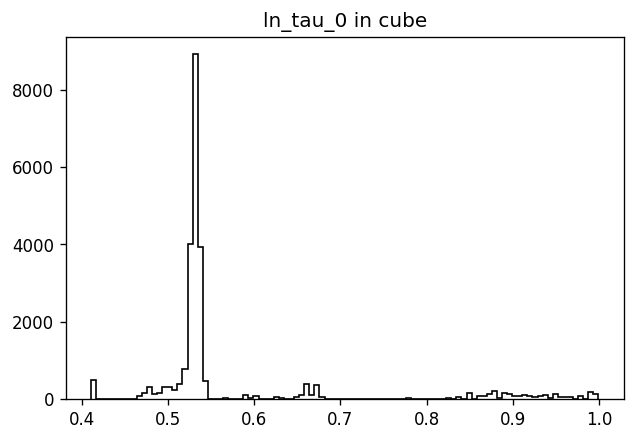

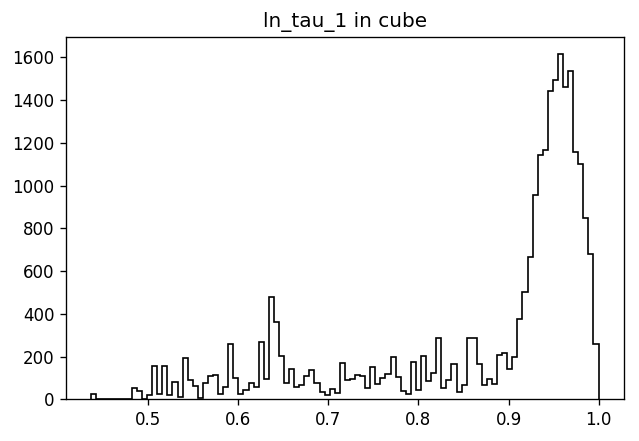

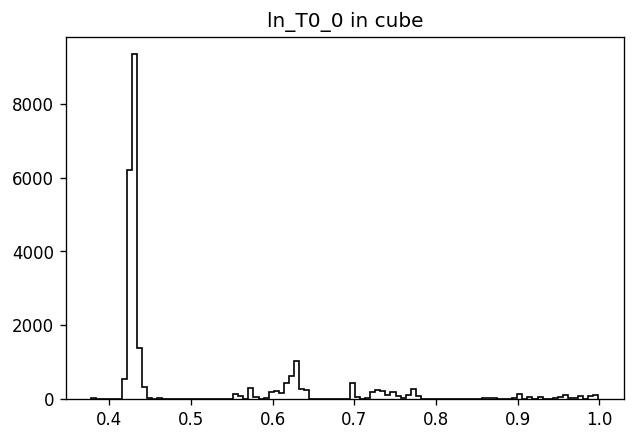

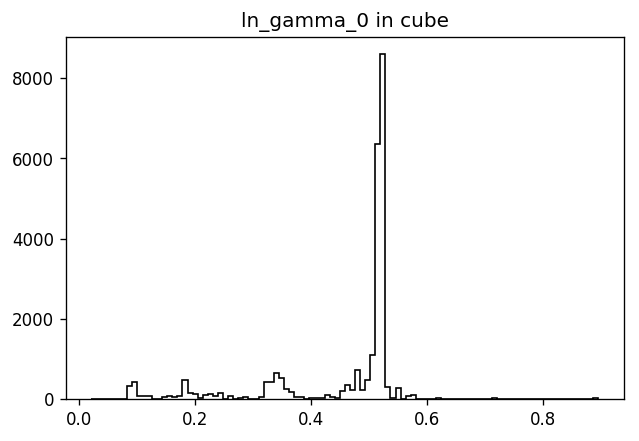

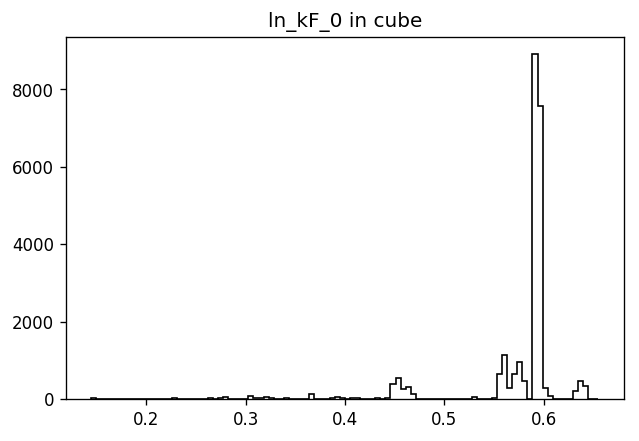

In [11]:
sampler.plot_histograms(cube=True)

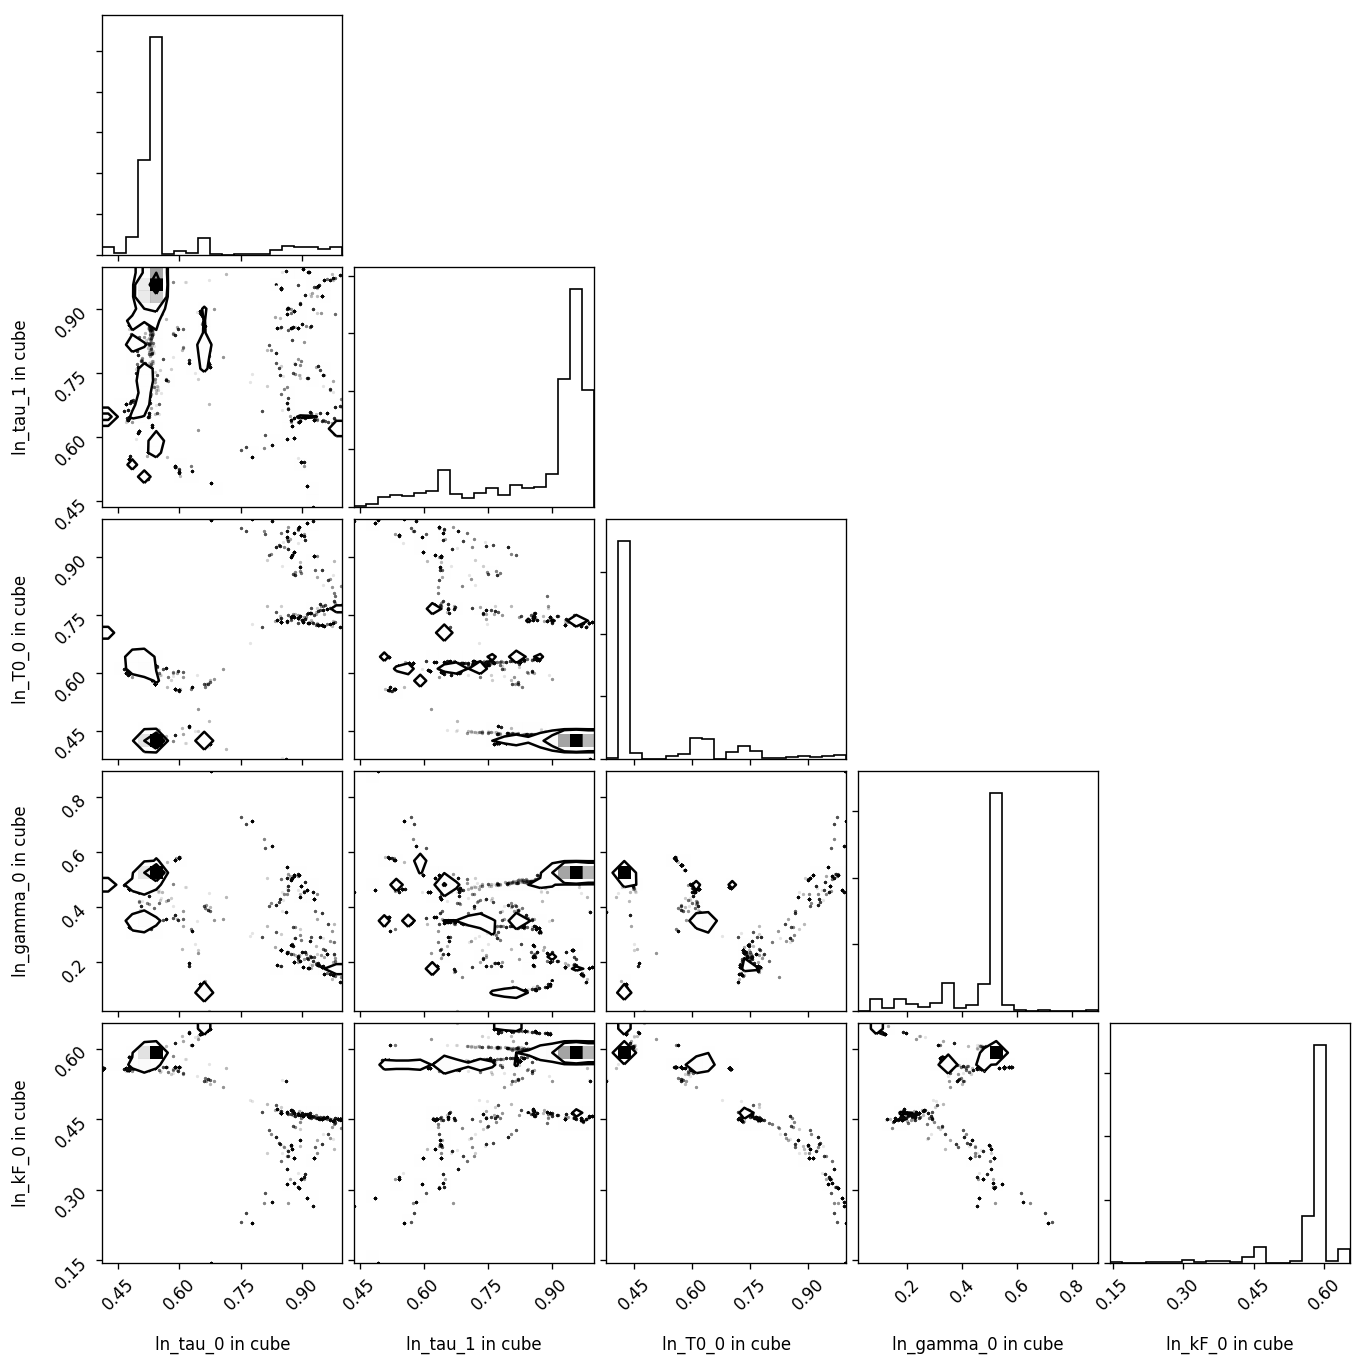

In [12]:
sampler.plot_corner(cube=True)

### Plot results for dimensional parameters

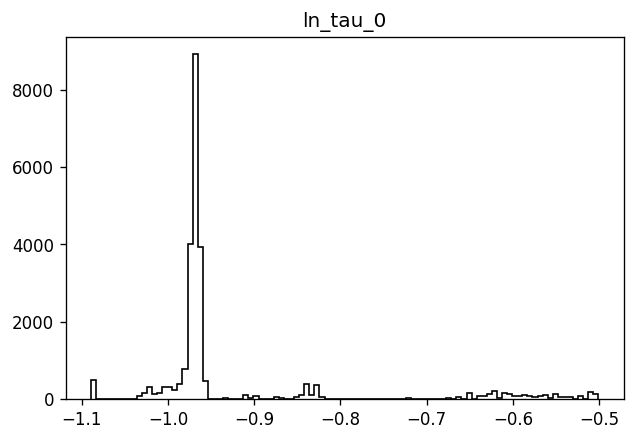

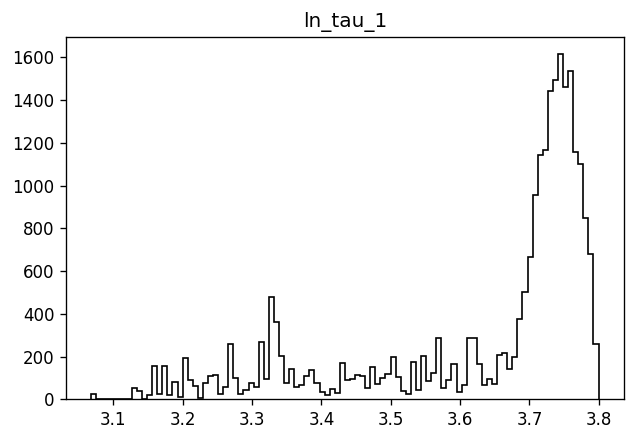

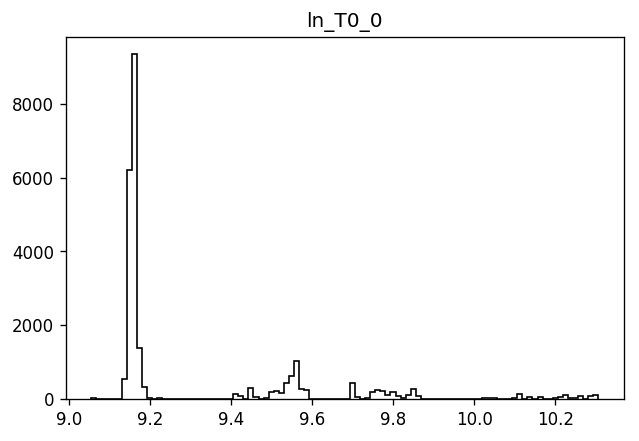

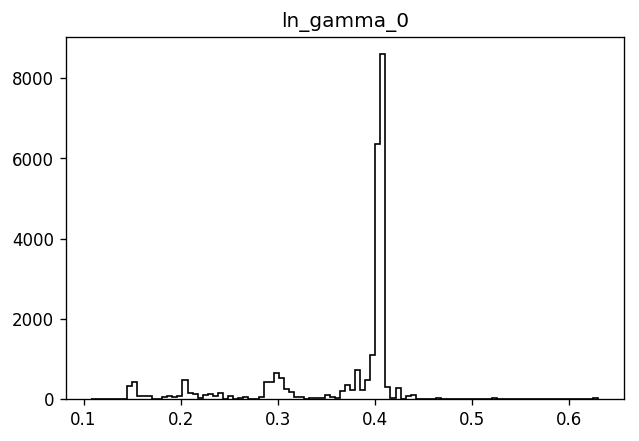

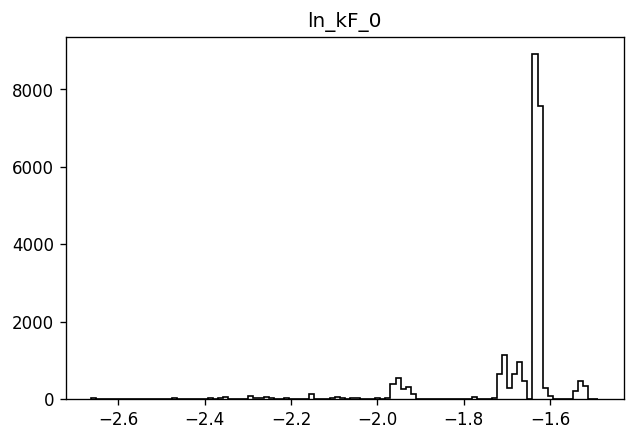

In [13]:
sampler.plot_histograms(cube=False)

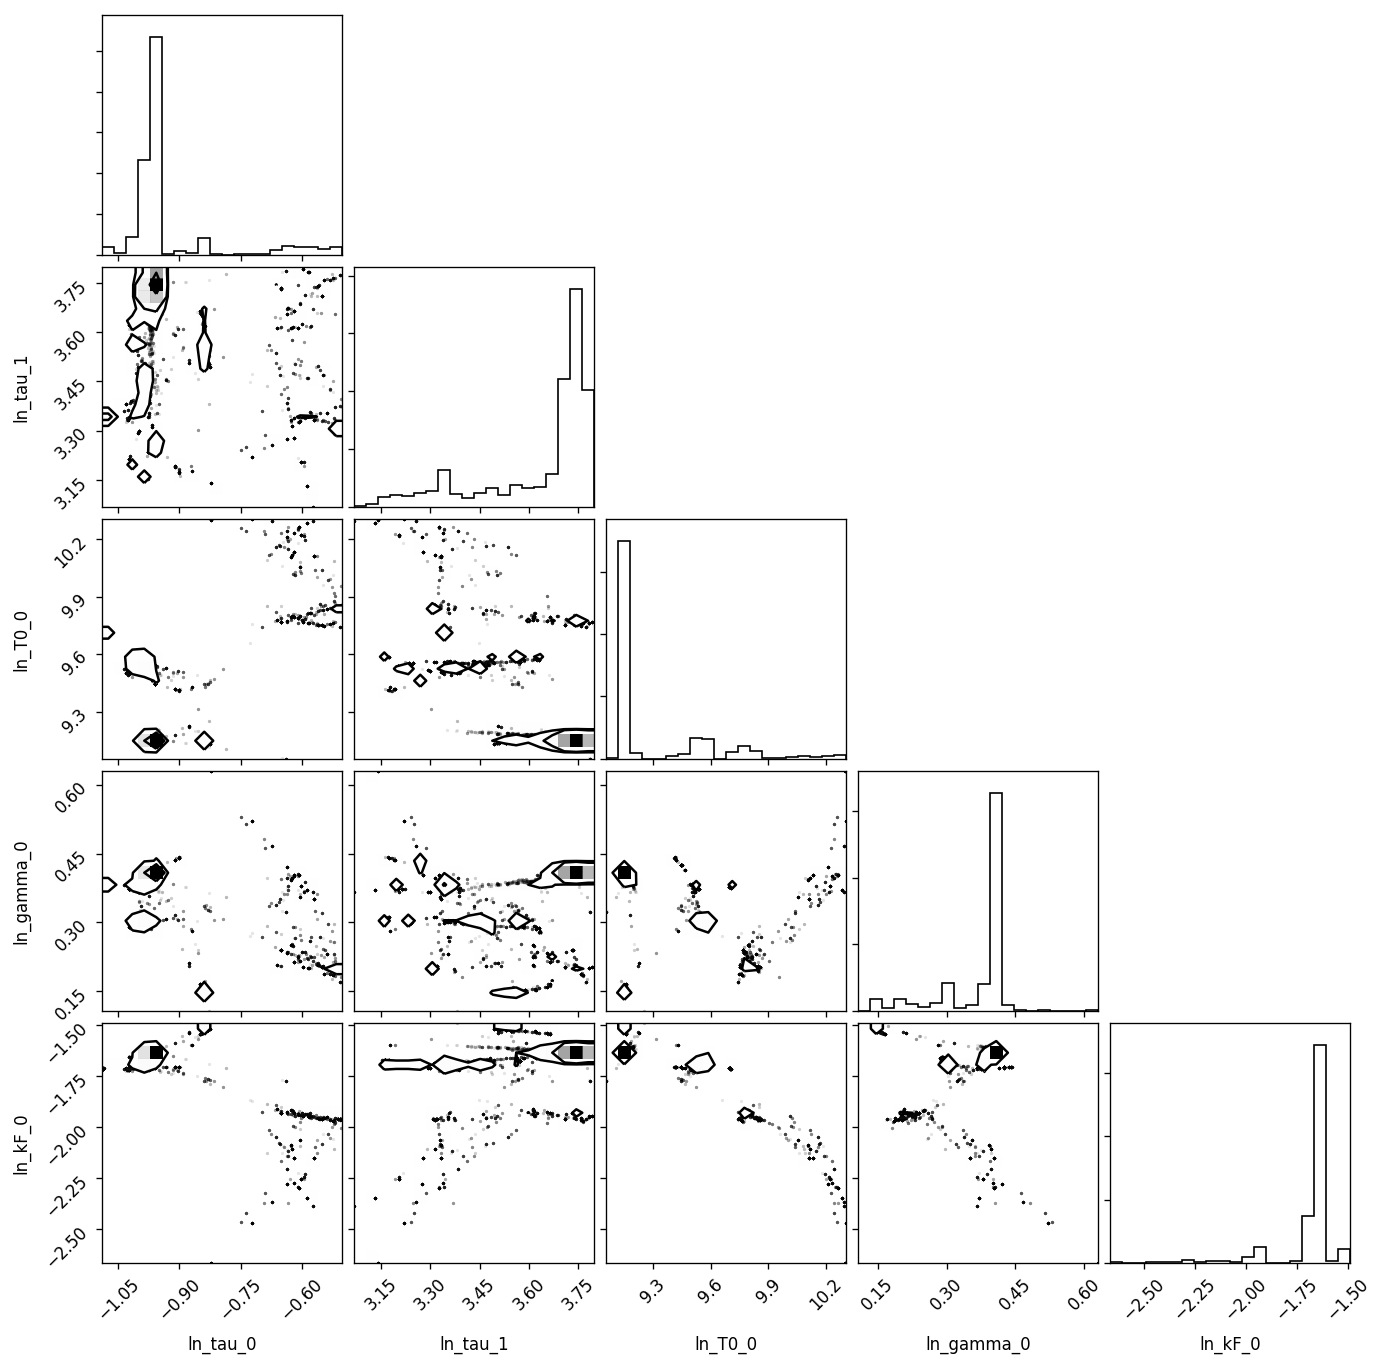

In [14]:
sampler.plot_corner(cube=False)

### Use likelihood object to make other useful plots

In [15]:
# get best fit model
ind = np.unravel_index(np.argmax(sampler.sampler.lnprobability, axis=None), sampler.sampler.lnprobability.shape)
best_fit=sampler.sampler.chain[ind]

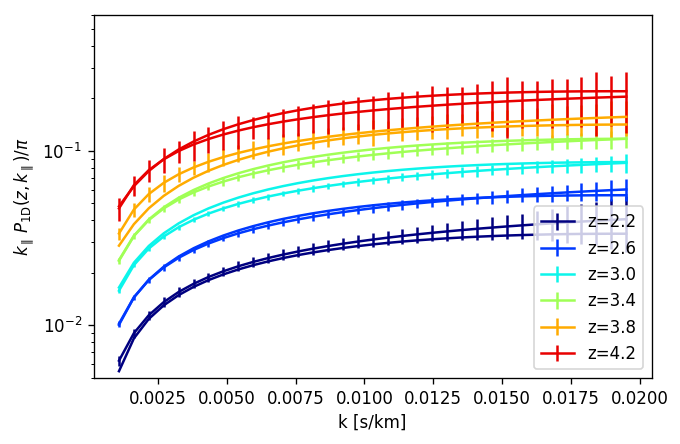

In [16]:
sampler.like.plot_p1d(values=best_fit,plot_every_iz=2)

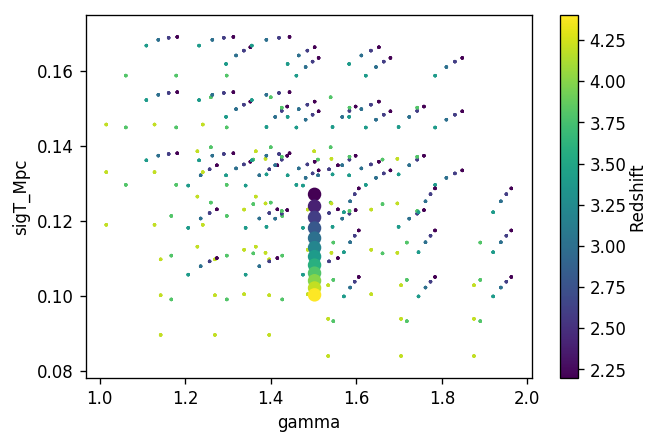

In [17]:
sampler.like.overplot_emulator_calls('gamma','sigT_Mpc',values=best_fit)

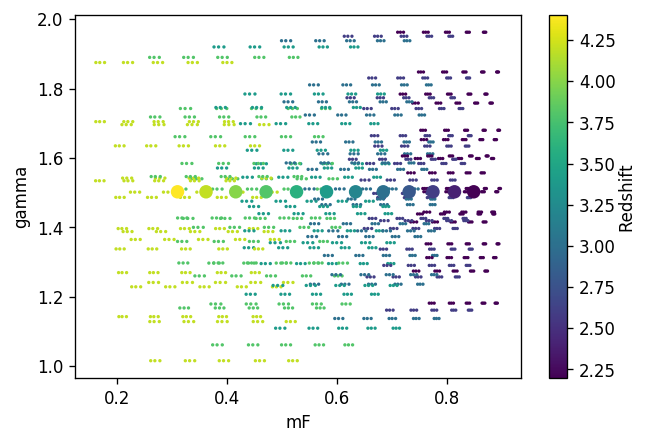

In [18]:
sampler.like.overplot_emulator_calls('mF','gamma',values=best_fit)

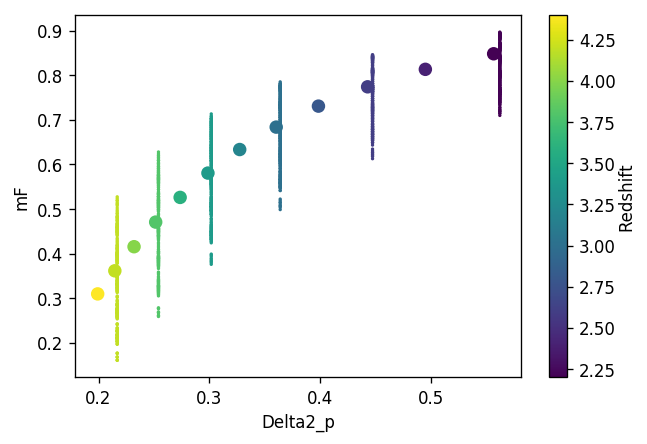

In [19]:
sampler.like.overplot_emulator_calls('Delta2_p','mF',values=best_fit)

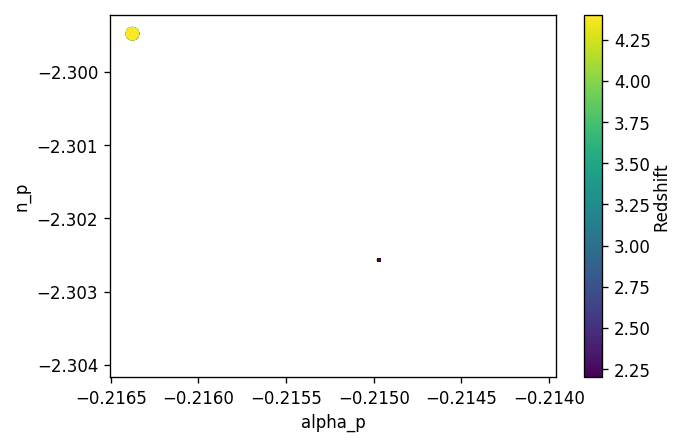

In [20]:
sampler.like.overplot_emulator_calls('alpha_p','n_p',values=best_fit)

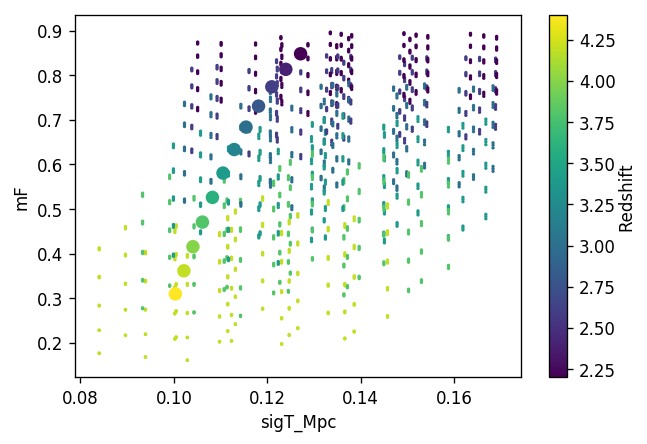

In [21]:
sampler.like.overplot_emulator_calls('sigT_Mpc','mF',values=best_fit)

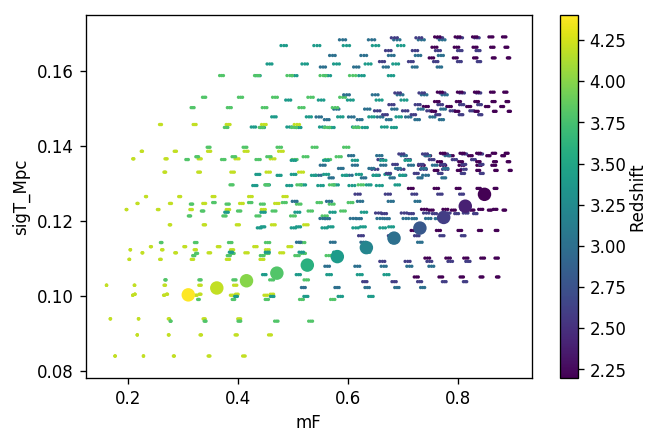

In [22]:
sampler.like.overplot_emulator_calls('mF','sigT_Mpc',values=best_fit)

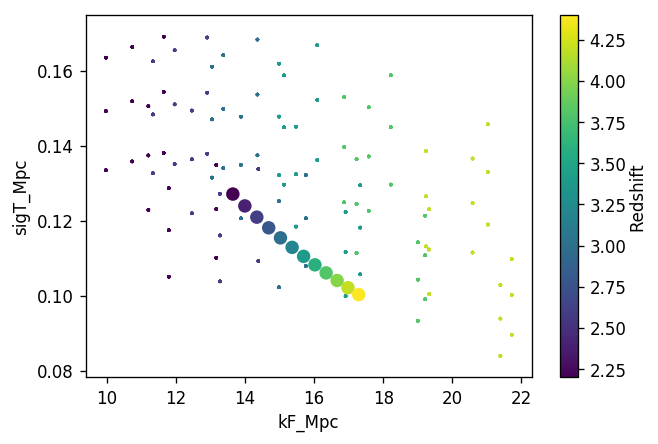

In [23]:
sampler.like.overplot_emulator_calls('kF_Mpc','sigT_Mpc',values=best_fit)

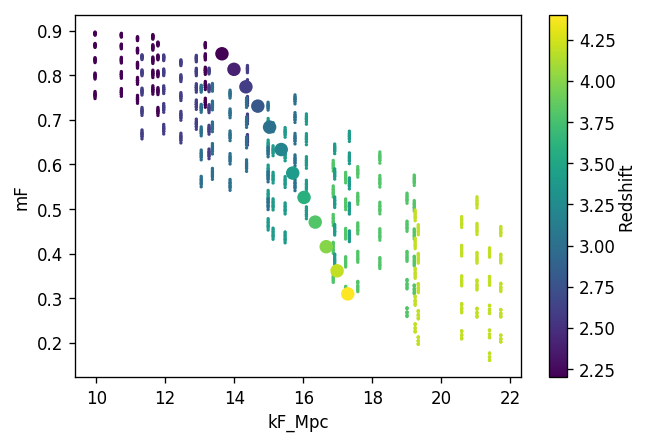

In [24]:
sampler.like.overplot_emulator_calls('kF_Mpc','mF',values=best_fit)

### Write chain to file for later use

In [25]:
chain_filename='test'
sampler.write_chain_to_file(chain_filename)

### Read pre-computed chain

In [26]:
new_sampler = emcee_sampler.EmceeSampler(emulator=emu,free_parameters=free_parameters,
                                         read_chain_file=chain_filename,verbose=True)

use default likelihood
Note: redshifts have been re-sorted (earliest first)
will read chain from file test
done setting up sampler


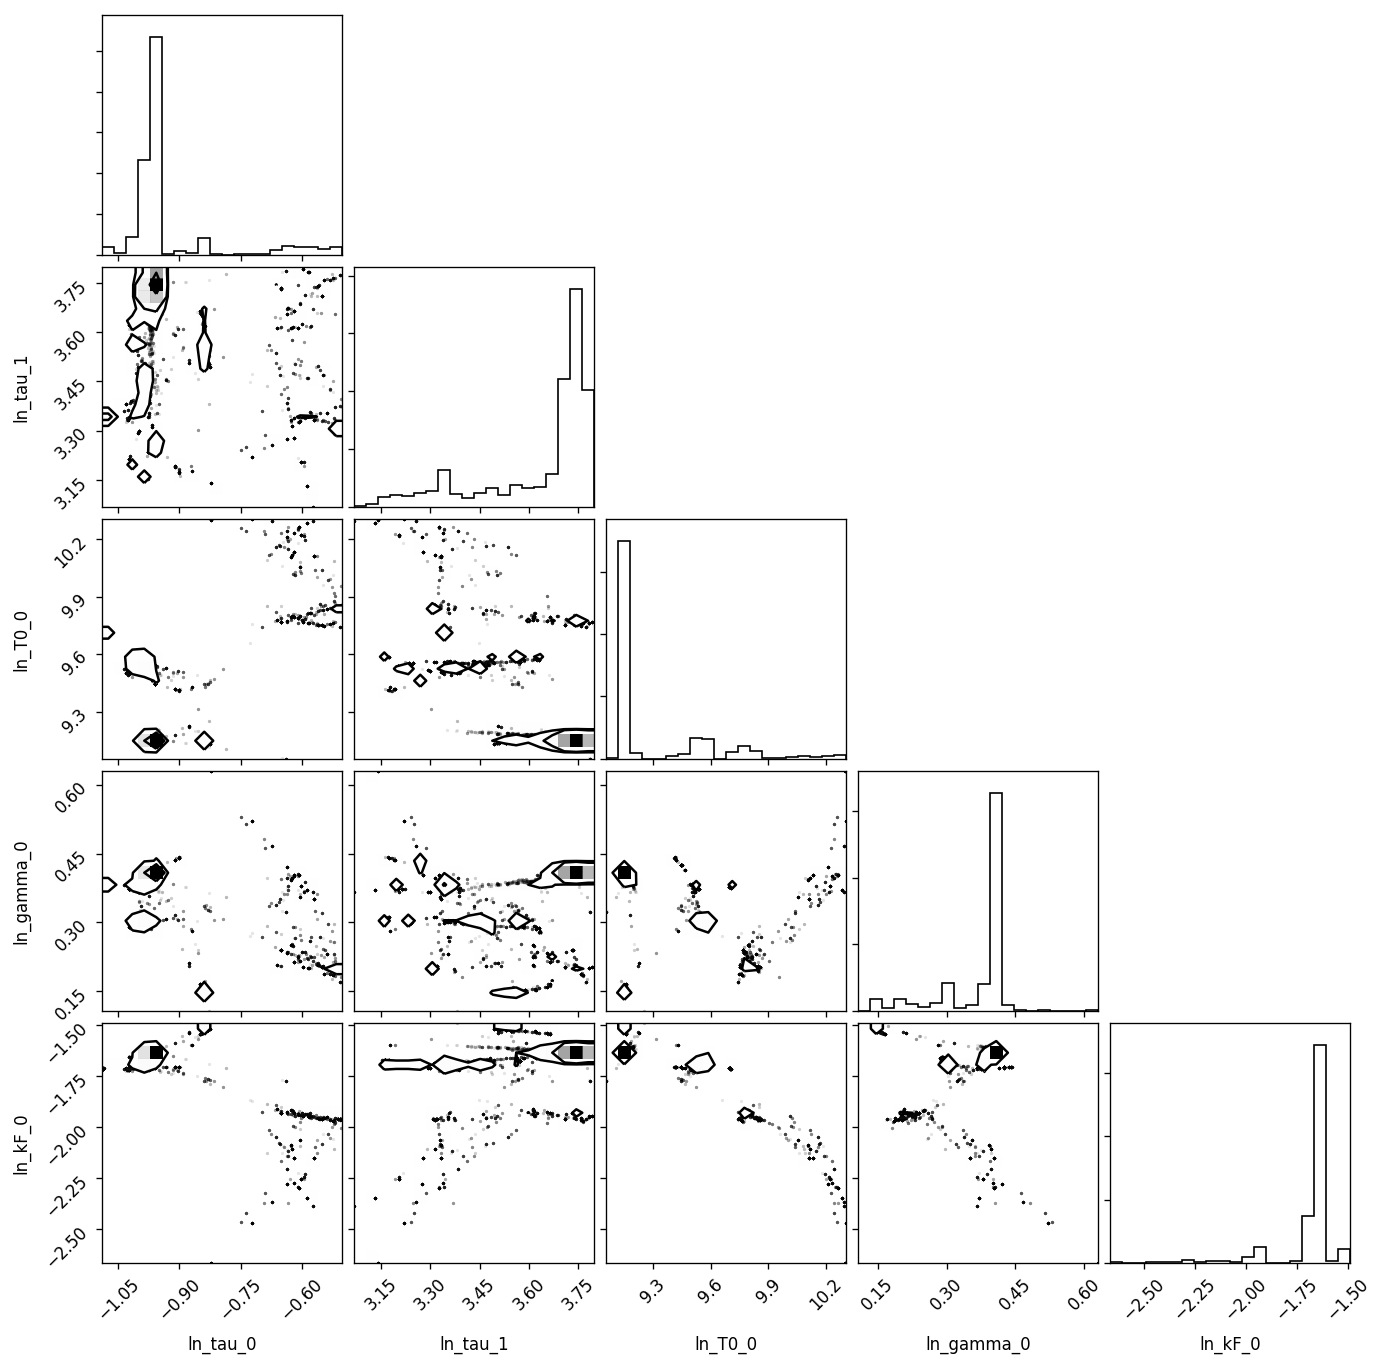

In [27]:
new_sampler.plot_corner(cube=False)

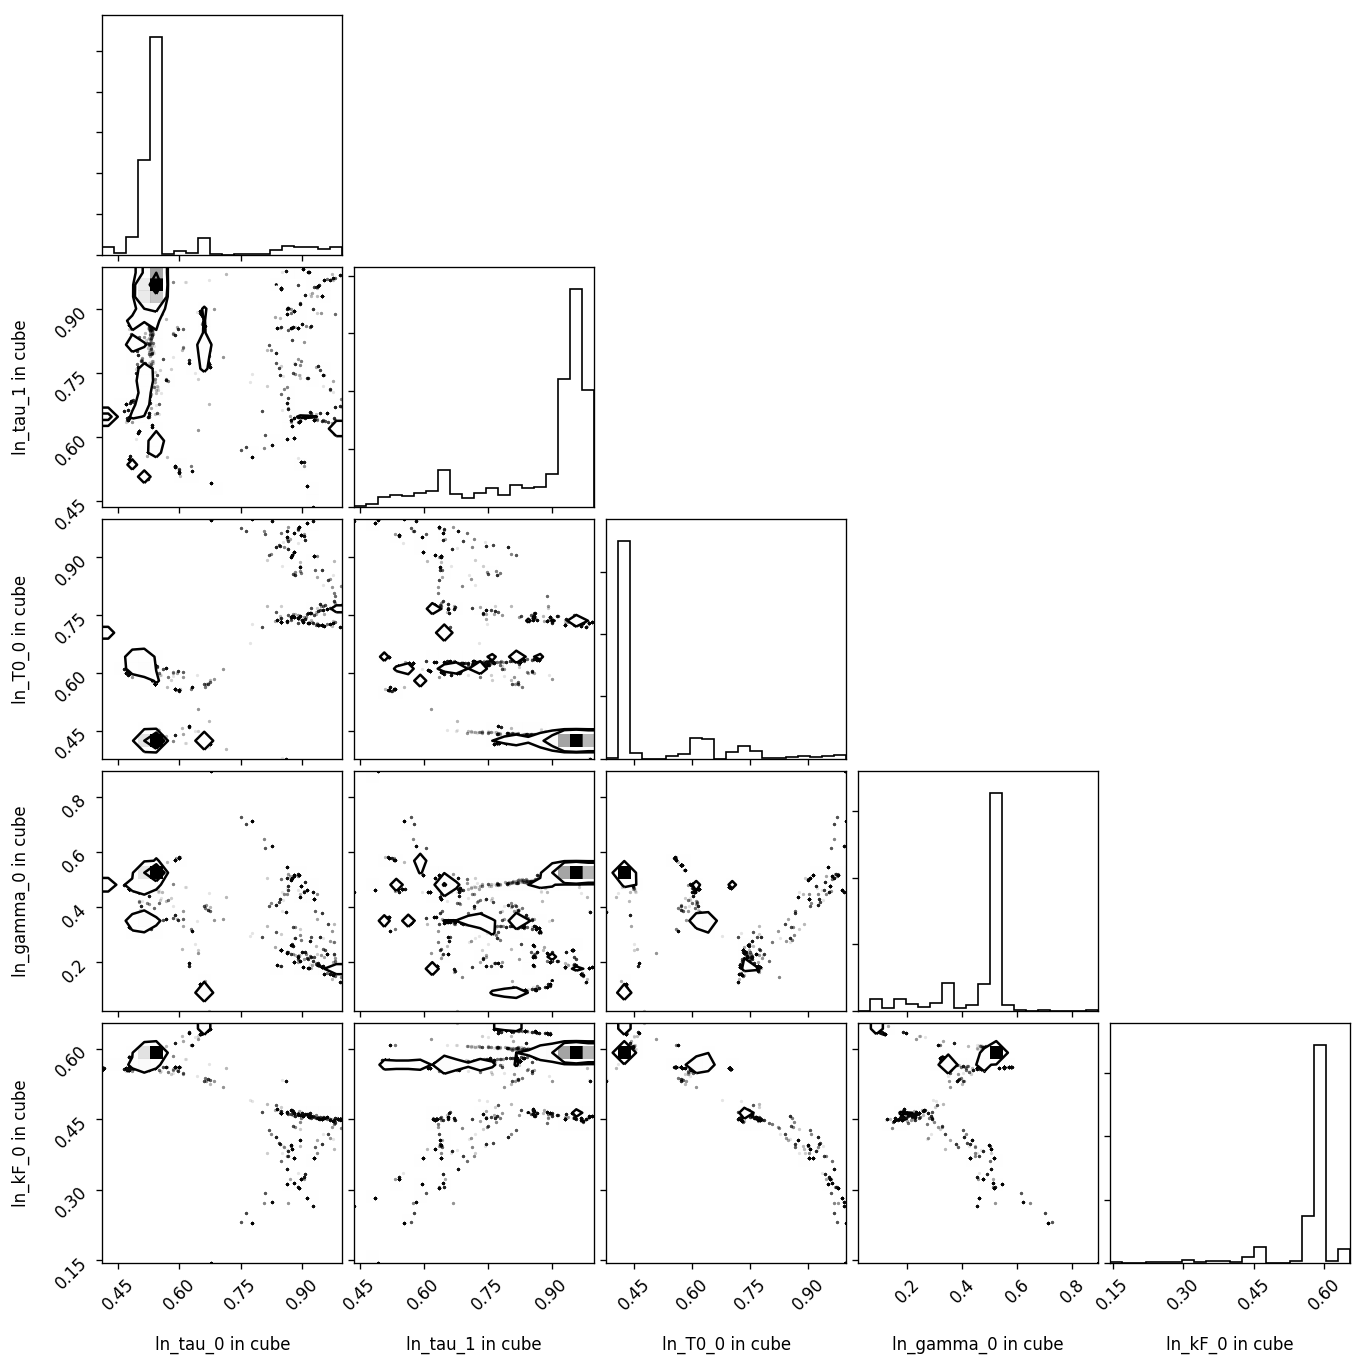

In [28]:
new_sampler.plot_corner(cube=True)

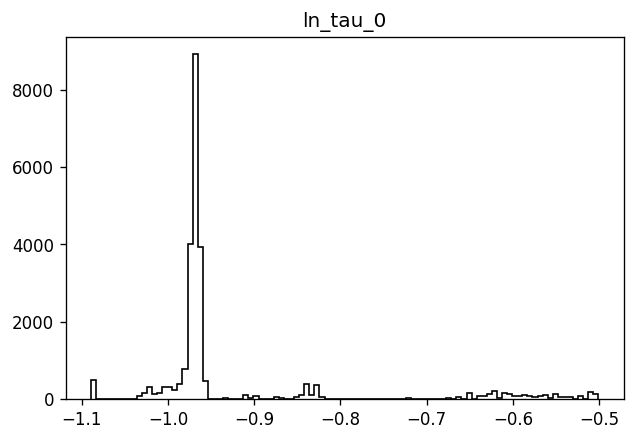

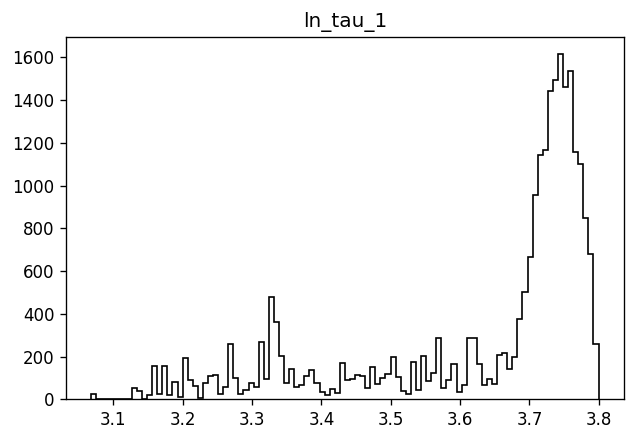

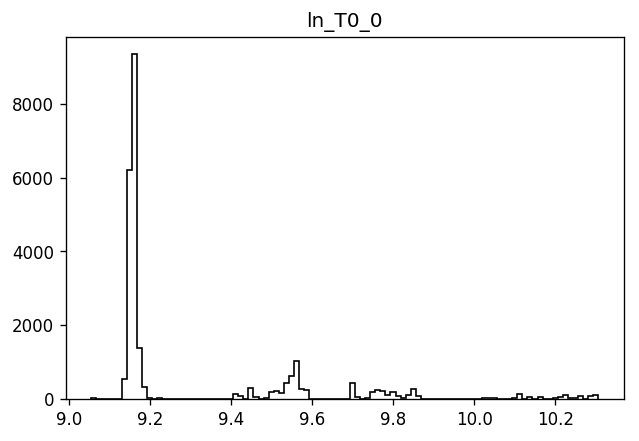

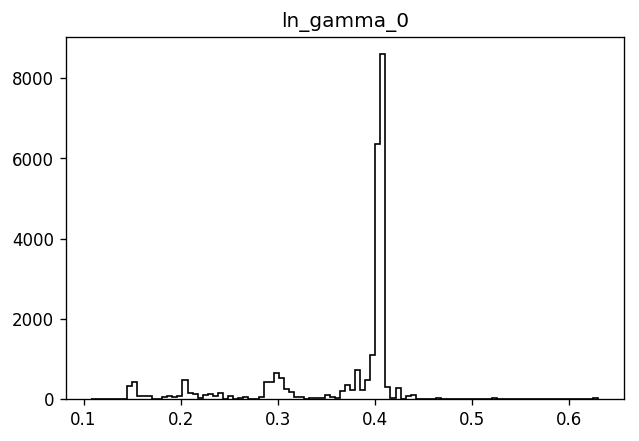

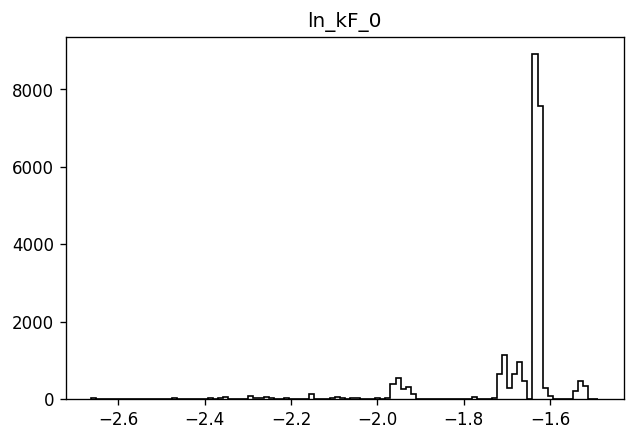

In [29]:
new_sampler.plot_histograms(cube=False)